# Conflict Analysis in Haiti

In [238]:
%reload_ext autoreload
%autoreload 2

from dotenv import load_dotenv
import os
import pandas as pd


import os
from acled_conflict_analysis import processing
from acled_conflict_analysis import extraction
from acled_conflict_analysis import visuals
from datetime import datetime
# Import the OAuth authentication function
from acled_conflict_analysis.acled_auth import *
from boundaries import *
import geopandas as gpd

# Load environment variables
load_dotenv()

# Get Mapbox basemap URL from environment
MAPBOX_BASEMAP_URL = os.getenv('MAPBOX_BASEMAP_URL', '')

In [239]:
# Suppress font warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='IPython.core.events')
warnings.filterwarnings('ignore', message='.*Glyph.*missing from font.*')

In [240]:
from boundaries import get_boundaries, get_admin1_boundaries

# Get Haiti country boundary (admin 0)
haiti_adm0 = get_boundaries('ISO_A3', 'HTI')
haiti_adm0 = gpd.GeoDataFrame(haiti_adm0, geometry='rings',crs='EPSG:4326')
country_boundary = haiti_adm0.loc['attributes', 'rings']

# Get Haiti department boundaries (admin 1)
haiti_adm1 = get_admin1_boundaries('HTI')
haiti_adm1 = gpd.GeoDataFrame(haiti_adm1, geometry='geometry',crs='EPSG:4326')

haiti_adm2 = get_admin2_boundaries('HTI')
haiti_adm2 = gpd.GeoDataFrame(haiti_adm2, geometry='geometry',crs='EPSG:4326')



Found 10 admin 1 subdivisions for HTI
Found 41 admin 2 subdivisions for HTI


In [241]:
haiti_adm3 = gpd.read_file('../data/boundaries/hti_admin_boundaries.shp/hti_admin3.shp')

In [242]:
COUNTRIES_OF_INTEREST = ["Haiti"]

TODAY_DATE = datetime.today().date().isoformat()

START_DATE = "2024-01-01"
END_DATE = "2025-12-31"

In [243]:
# ============================
# LOAD AND PREPROCESS DATA
# ============================
# Load environment variables from .env file
# to ensure we can access API keys
load_dotenv()

# Extract the data
# Test single call to check for duplicate prints
print("🧪 Testing acled_api function for duplicate prints...")

data = extraction.acled_api(
    #email = acled_email,
    #password = acled_password,
    country_codes=COUNTRIES_OF_INTEREST,
    start_date=START_DATE,
    end_date=END_DATE  # Small date range for quick test
)
# Perfom data conversion
processing.data_type_conversion(data)

🧪 Testing acled_api function for duplicate prints...
🔄 Using cached OAuth token
URL: https://acleddata.com/api/acled/read
Parameters: {'_format': 'json', 'limit': 4000000, 'iso': '332', 'event_date': '2024-01-01|2025-12-31', 'event_date_where': 'BETWEEN', 'population': 'full', 'fields': 'region|country|iso|year|event_date|source|admin1|admin2|admin3|location|event_type|sub_event_type|interaction|fatalities|timestamp|latitude|longitude|actor1|actor2|notes|population_1km|population_5km|population_2km|population_best'}
✅ Successfully retrieved 4327 records


In [244]:
data["nrEvents"] = 1
#data = data[data['event_type']!='Strategic developments']

In [245]:
def get_conflict_category(date):
    if date <= pd.Timestamp("2024-12-31") and date >= pd.Timestamp("2024-01-01"):
        return "2024"
    elif date >= pd.Timestamp("2025-01-01") and date <= pd.Timestamp("2025-12-31"):
        return "2025"

In [246]:
data.loc[:, "category"] = data["event_date"].apply(get_conflict_category)
extracted_date = datetime.today().date().isoformat()
extracted_date_formatted = datetime.today().strftime('%B %d, %Y')

In [247]:
data.to_csv(f'../data/conflict/raw_acled_{extracted_date}.csv')
data = pd.read_csv(f"../data/conflict/raw_acled_{extracted_date}.csv")
processing.data_type_conversion(data)

In [248]:
conflict_daily = processing.get_acled_by_group(
    data, columns=["latitude", "longitude", "category"], freq="D"
)

In [249]:
daily_mean = (
    conflict_daily.groupby(["category", "latitude", "longitude"])[
        ["nrEvents", "nrFatalities"]
    ]
    .mean()
    .reset_index()
)
daily_median = (
    conflict_daily.groupby(["category", "latitude", "longitude"])[
        ["nrEvents", "nrFatalities"]
    ]
    .median()
    .reset_index()
)

In [250]:
daily_mean = processing.convert_to_gdf(daily_mean)
daily_median = processing.convert_to_gdf(daily_median)

## Mean Conflict Index

The conflict intensity index is calculated as the geometric mean of conflict events and fatalities, with an adjustment to handle zero values:

$$\text{Conflict Intensity Index} = \sqrt{(\text{nrEvents}) \times (\text{nrFatalities} + 1)}$$

Where:
- $\text{nrEvents}$ is the number of conflict events in a given period and location
- $\text{nrFatalities}$ is the number of fatalities from conflicts in the same period and location
- The addition of 1 to each term ensures the index is defined even when either component is zero. This is arbitrary and is doen just to account for 0 values of fatalities and conflicts. 

This index provides a balanced measure that accounts for both the frequency of conflicts and their severity.  Compared to arithmetic means, the geometric mean reduces the influence of extreme values in either component (conflict events + fatalities). Areas with both high events and high fatalities will have higher index values than areas with many events but few fatalities or vice versa.

Conflict index is calculated at the location and then average is taken over time (across the three time periods). This is to preserve the integrity of the conflict index in that specific location. 

In [251]:
import numpy as np
conflict_daily["conflict_intensity_index_op1"] = np.sqrt(
    (conflict_daily["nrEvents"]) * (conflict_daily["nrFatalities"] + 1)
)
daily_conflict_intensity = (
    conflict_daily.groupby(["category", "latitude", "longitude"])[
        ["nrEvents", "nrFatalities", "conflict_intensity_index_op1"]
    ]
    .mean()
    .reset_index()
)
daily_conflict_intensity = processing.convert_to_gdf(daily_conflict_intensity)

In [252]:
import numpy as np
conflict_daily["conflict_intensity_index_op1"] = np.sqrt(
    (conflict_daily["nrEvents"]) * (conflict_daily["nrFatalities"] + 1)
)

In [253]:
h3_gdf = processing.convert_to_h3_grid(haiti_adm0, resolution=6)

In [254]:
data["event_date"] = pd.to_datetime(data["event_date"])

In [255]:
conflict_daily_h3 = processing.get_acled_by_admin(
    h3_gdf, data, columns=["h3_index", "category"], freq="D"
)
conflict_daily_h3.drop(columns=["index"], inplace=True)

conflict_daily_h3["conflict_intensity_index_op1"] = np.sqrt(
    (conflict_daily_h3["nrEvents"]) * (conflict_daily_h3["nrFatalities"] + 1)
)

# calculating average 'daily' conflict index
conflict_daily_h3_mean = (
    conflict_daily_h3.groupby(["h3_index", "category"])[
        ["nrEvents", "nrFatalities", "conflict_intensity_index_op1"]
    ]
    .mean()
    .reset_index()
)

conflict_daily_h3_mean = h3_gdf.merge(
    conflict_daily_h3_mean, on="h3_index", how="left"
)

In [256]:
conflict_daily_adm2 = processing.get_acled_by_admin(
    haiti_adm2, data, columns=["NAM_2","ADM2CD_c", "category"], freq="D"
)
conflict_daily_adm2.drop(columns=["index"], inplace=True)

conflict_daily_adm2["conflict_intensity_index_op1"] = np.sqrt(
    (conflict_daily_adm2["nrEvents"]) * (conflict_daily_adm2["nrFatalities"] + 1)
)

# calculating average 'daily' conflict index
conflict_daily_adm2_mean = (
    conflict_daily_adm2.groupby(["NAM_2","ADM2CD_c", "category"])[
        ["nrEvents", "nrFatalities", "conflict_intensity_index_op1"]
    ]
    .mean()
    .reset_index()
)

conflict_daily_adm2_mean = haiti_adm2.merge(
    conflict_daily_adm2_mean, on=["NAM_2", "ADM2CD_c"], how="left"
)

In [257]:
conflict_daily_adm3 = processing.get_acled_by_admin(
    haiti_adm3, data, columns=["adm1_name1","adm2_name1","adm3_name","adm3_pcode", "category"], freq="D"
)
conflict_daily_adm3.drop(columns=["index"], inplace=True)

conflict_daily_adm3["conflict_intensity_index_op1"] = np.sqrt(
    (conflict_daily_adm3["nrEvents"]) * (conflict_daily_adm3["nrFatalities"] + 1)
)

# calculating average 'daily' conflict index
conflict_daily_adm3_mean = (
    conflict_daily_adm3.groupby(["adm1_name1","adm2_name1","adm3_name","adm3_pcode", "category"])[
        ["nrEvents", "nrFatalities", "conflict_intensity_index_op1"]
    ]
    .mean()
    .reset_index()
)

conflict_daily_adm3_mean = haiti_adm3.merge(
    conflict_daily_adm3_mean, on=["adm1_name1","adm2_name1","adm3_name","adm3_pcode"], how="left"
)

In [258]:
category_list = [2024, 2025]

In [259]:
h3_gdf_area = h3_gdf.copy()
h3_gdf_area = h3_gdf_area.to_crs(epsg=32618)
h3_gdf_area['area_km2'] = h3_gdf_area['geometry'].area / 1e6
avg_area = h3_gdf_area['area_km2'].mean()
print(f"Average area of H3 grid cells at resolution 6: {avg_area:.2f} km²")

Average area of H3 grid cells at resolution 6: 27.51 km²


## Daily Average Conflict Index in 2024 vs 2025 

This map shows conflict index at at ~27 sqkm resolution. 

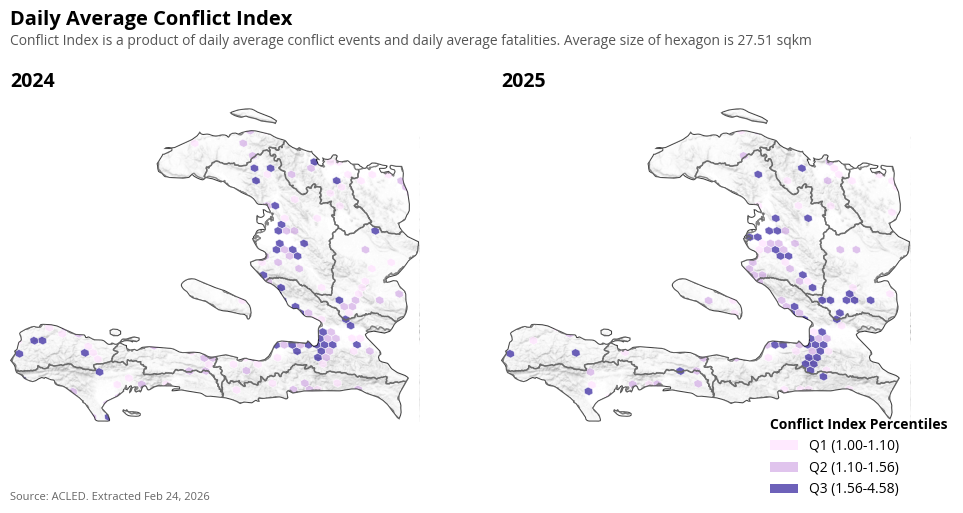

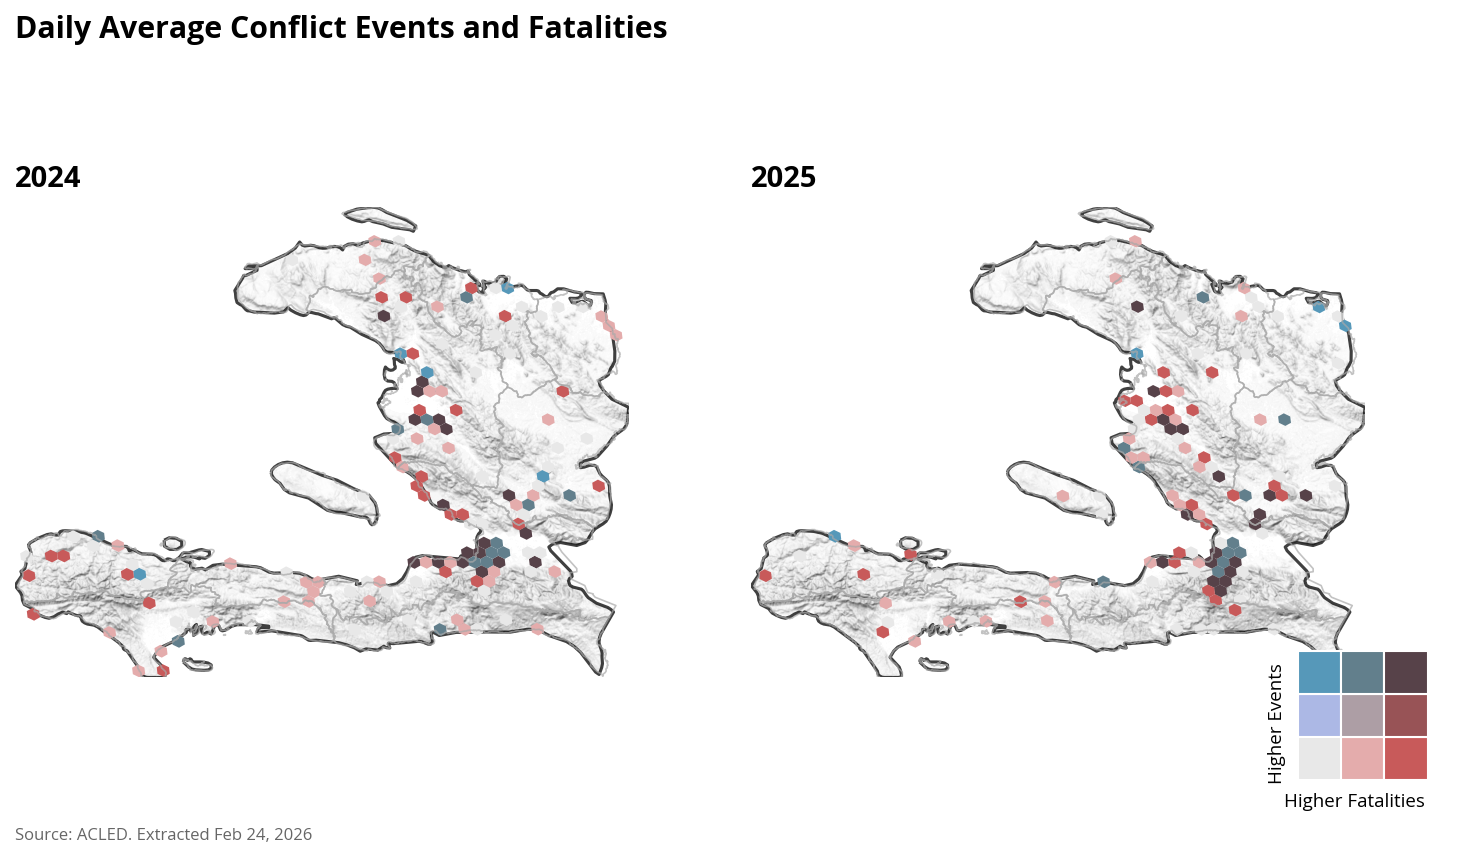

In [260]:


fig, ax = visuals.get_h3_maps(
    conflict_daily_h3_mean, 
    title = 'Daily Average Conflict Index', 
    subtitle=f'Conflict Index is a product of daily average conflict events and daily average fatalities. Average size of hexagon is {avg_area:.2f} sqkm',
    measure='conflict_intensity_index_op1',
    category_list=category_list,
    custom_colors=['#FFE2FF',
'#D3ACE6',
'#2F1E9C'],
    country_boundary=haiti_adm0,
    admin1_boundary=haiti_adm1,
    basemap_choice=MAPBOX_BASEMAP_URL,
    basemap_alpha=0.5,
    # date_ranges={
    #     'Before Regime Change': 'Nov 26, 2023 - Nov 27, 2024',
    #     'After Regime Change': 'Dec 8, 2024 - Dec 9, 2025'
    # },
    legend_title='Conflict Index Percentiles'
)

fig, ax = visuals.create_bivariate_map_with_basemap(
    conflict_data=conflict_daily_h3_mean,
    category_list=category_list,
    country_boundary=haiti_adm0,
    admin1_boundary=haiti_adm1,
    main_title="Daily Average Conflict Events and Fatalities",
    basemap_choice=MAPBOX_BASEMAP_URL,
    basemap_alpha=1,
    hexagon_alpha=1,
    # date_ranges={
    #     2024: 'Nov 26, 2023 - Nov 27, 2024',
    #     'After Regime Change': 'Dec 8, 2024 - Dec 9, 2025'
    # }
)

In [261]:
conflict_pc_diff_h3 = conflict_daily_h3_mean.dropna(subset=['category']).copy()
conflict_pc_diff_h3['conflict_intensity_index_op1'] = conflict_pc_diff_h3['conflict_intensity_index_op1'].fillna(0)
conflict_pc_diff_h3 = conflict_pc_diff_h3.pivot_table(index='h3_index', columns='category', values='conflict_intensity_index_op1', aggfunc='mean').reset_index()
conflict_pc_diff_h3[2025] = conflict_pc_diff_h3[2025].fillna(0)
conflict_pc_diff_h3['pc_change'] = 100*(conflict_pc_diff_h3[2025] - conflict_pc_diff_h3[2024]) / (conflict_pc_diff_h3[2024])

# Melt to get categories as rows
conflict_pc_diff_melted = conflict_pc_diff_h3.melt(
    id_vars=['h3_index', 'pc_change'], 
    value_vars=[2024, 2025],
    var_name='category', 
    value_name='conflict_intensity_index_op1'
)
conflict_pc_diff_melted = conflict_pc_diff_melted[conflict_pc_diff_melted['category']==2025]

conflict_pc_diff_melted = h3_gdf.merge(conflict_pc_diff_melted, on='h3_index', how='left')

## Change in Daily Average Conflict Index in 2025

### Change in ~27 sqkm hexagons

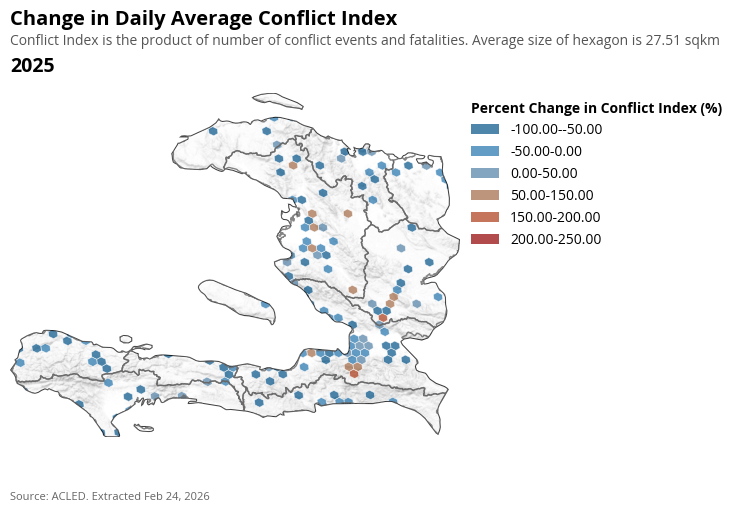

In [262]:

custom_bin_edges = [-100,-50,0,50,150,200,250]

fig, ax = visuals.get_h3_maps(
    conflict_pc_diff_melted, 
    'Change in Daily Average Conflict Index', 
    subtitle=f'Conflict Index is the product of number of conflict events and fatalities. Average size of hexagon is {avg_area:.2f} sqkm',
    measure='pc_change',
    category_list=[2025],
    custom_colors=[
'#025288',
'#3587C3',
'#BD6126',
'#920000',
],
 legend_bbox=(1.5, 0.5),
    country_boundary=haiti_adm0,
    admin1_boundary=haiti_adm1,
    basemap_choice=MAPBOX_BASEMAP_URL,
    basemap_alpha=0.5,
    custom_bins=custom_bin_edges,  # Custom classification bins
    legend_title='Percent Change in Conflict Index (%)',
    #basemap_choice=MAPBOX_BASEMAP_URL
)

### Change in Arrondissements (ADM2)

In [263]:
conflict_pc_diff_adm2 = conflict_daily_adm2.copy()
conflict_pc_diff_adm2['conflict_intensity_index_op1'] = conflict_pc_diff_adm2['conflict_intensity_index_op1'].fillna(0)
conflict_pc_diff_adm2 = conflict_pc_diff_adm2.pivot_table(index='NAM_2', columns='category', values='conflict_intensity_index_op1', aggfunc='mean').reset_index()
conflict_pc_diff_adm2['pc_change'] = 100*(conflict_pc_diff_adm2[2025] - conflict_pc_diff_adm2[2024]) / (conflict_pc_diff_adm2[2024])

# Melt to get categories as rows
conflict_pc_diff_melted = conflict_pc_diff_adm2.melt(
    id_vars=['NAM_2', 'pc_change'], 
    value_vars=[2024, 2025],
    var_name='category', 
    value_name='conflict_intensity_index_op1'
)
conflict_pc_diff_melted = conflict_pc_diff_melted[conflict_pc_diff_melted['category']==2025]

conflict_pc_diff_melted = haiti_adm2.merge(conflict_pc_diff_melted, on='NAM_2', how='left')

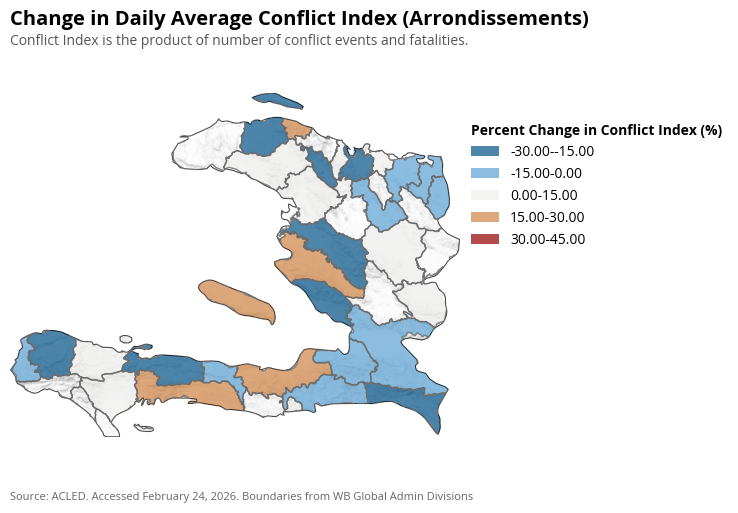

In [264]:
# Example 3: Custom bin edges for classification
# Define fixed bins: 0-5 events (low), 5-15 events (medium), 15+ events (high)
custom_bin_edges = [-30,-15,0,15,30, 45]

fig, ax = visuals.get_h3_maps(
    conflict_pc_diff_melted, 
    'Change in Daily Average Conflict Index (Arrondissements)', 
    subtitle='Conflict Index is the product of number of conflict events and fatalities. ',
    source_text=f'Source: ACLED. Accessed {extracted_date_formatted}. Boundaries from WB Global Admin Divisions',
    measure='pc_change',
    category_list=[2025],
    custom_colors=["#025288", "#3587C3", "#80BDE7", "#EFEFEF", "#E3A763", "#BD6126", "#920000"],
    country_boundary=haiti_adm0,
    admin1_boundary=haiti_adm2,
    basemap_choice=MAPBOX_BASEMAP_URL,
    basemap_alpha=0.5,
    custom_bins=custom_bin_edges,  # Custom classification bins
    subplot_titles=[],  
    legend_bbox=(1.5, 0.5),
    legend_title='Percent Change in Conflict Index (%)',
    #basemap_choice=MAPBOX_BASEMAP_URL
)

### Change in Districts ADM3

In [265]:
conflict_pc_diff_adm3 = conflict_daily_adm3.copy()
conflict_pc_diff_adm3['conflict_intensity_index_op1'] = conflict_pc_diff_adm3['conflict_intensity_index_op1'].fillna(0)
conflict_pc_diff_adm3 = conflict_pc_diff_adm3.pivot_table(index='adm3_name', columns='category', values='conflict_intensity_index_op1', aggfunc='mean').reset_index()
conflict_pc_diff_adm3['pc_change'] = 100*(conflict_pc_diff_adm3[2025] - conflict_pc_diff_adm3[2024]) / (conflict_pc_diff_adm3[2024])

# Melt to get categories as rows
conflict_pc_diff_melted = conflict_pc_diff_adm3.melt(
    id_vars=['adm3_name', 'pc_change'], 
    value_vars=[2024, 2025],
    var_name='category', 
    value_name='conflict_intensity_index_op1'
)
conflict_pc_diff_melted = conflict_pc_diff_melted[conflict_pc_diff_melted['category']==2025]

conflict_pc_diff_melted = haiti_adm3.merge(conflict_pc_diff_melted, on='adm3_name', how='left')

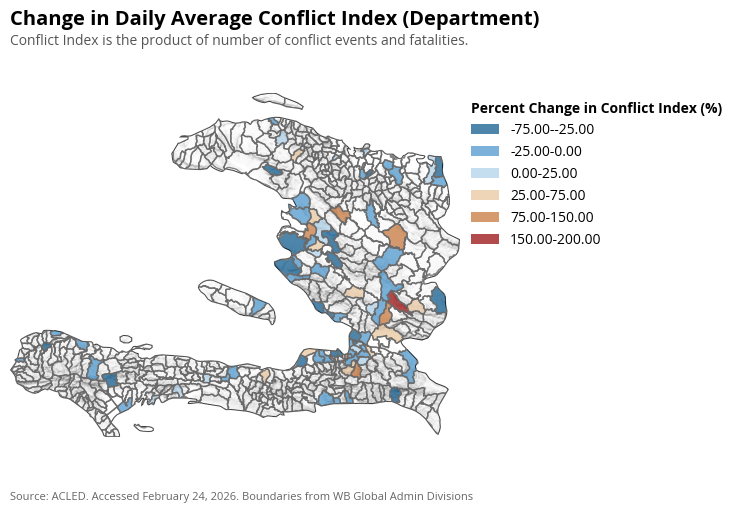

In [266]:
# Example 3: Custom bin edges for classification
# Define fixed bins: 0-5 events (low), 5-15 events (medium), 15+ events (high)
custom_bin_edges = [-75,-25,0,25,75,150,200]

fig, ax = visuals.get_h3_maps(
    conflict_pc_diff_melted, 
    'Change in Daily Average Conflict Index (Department)', 
    subtitle='Conflict Index is the product of number of conflict events and fatalities. ',
    source_text=f'Source: ACLED. Accessed {extracted_date_formatted}. Boundaries from WB Global Admin Divisions',
    measure='pc_change',
    category_list=[2025],
    custom_colors=["#025288", "#3587C3", "#80BDE7", "#EFEFEF", "#E3A763", "#BD6126", "#920000"],
    country_boundary=haiti_adm0,
    admin1_boundary=haiti_adm3,
    basemap_choice=MAPBOX_BASEMAP_URL,
    basemap_alpha=0.8,
    custom_bins=custom_bin_edges,  # Custom classification bins
    subplot_titles=[],  
    legend_bbox=(1.5, 0.5),
    legend_title='Percent Change in Conflict Index (%)',
    #basemap_choice=MAPBOX_BASEMAP_URL
)

## Conflict Near Roads

### Road Network in Haiti

/Users/ssarva/haiti-conflict-analysis/.venv/lib/python3.14/site-packages/pyogrio/raw.py:200: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured LineString' is converted to 'LineString'
  return ogr_read(
/Users/ssarva/haiti-conflict-analysis/.venv/lib/python3.14/site-packages/pyogrio/raw.py:200: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured LineString' is converted to 'LineString'
  return ogr_read(


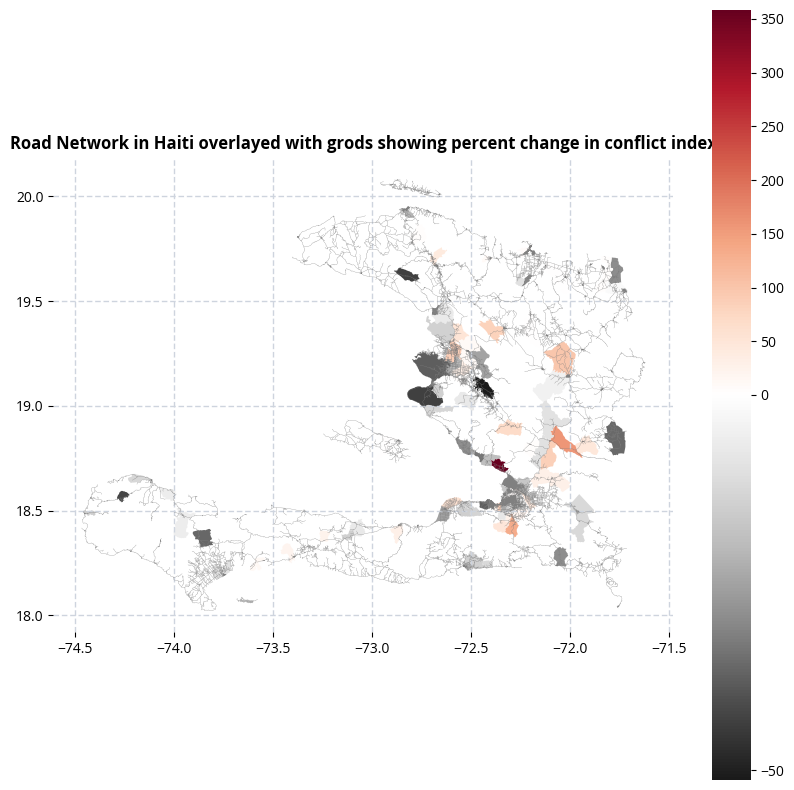

In [267]:
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
roads1 = gpd.read_file('../data/roads/route_cnigs_2019/R‚seau_Routier_Revetement.shp')
roads2 = gpd.read_file('../data/roads/route_cnigs_2019/R‚seau_Routier.shp')
roads3 = gpd.read_file('../data/roads/route_cnigs_2019/R‚seau_Routier_Praticabilit‚.shp')

roads2 = roads2.to_crs(epsg=4326)

# Create normalization with midpoint at 0
vmin = conflict_pc_diff_melted['pc_change'].min()
vmax = conflict_pc_diff_melted['pc_change'].max()
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

fig, ax = plt.subplots(figsize=(10, 10))
roads2.plot(ax=ax, alpha=0.95, color='grey', linewidth=0.2)
conflict_pc_diff_melted.plot(ax=ax, column='pc_change', cmap='RdGy_r', legend=True, norm=norm)
ax.set_title('Road Network in Haiti overlayed with grods showing percent change in conflict index');


## Major Conflict Types

In [268]:
conflict_type = processing.get_acled_by_group(data, ['event_type', 'sub_event_type', 'category'], freq='YS')
#conflict_type

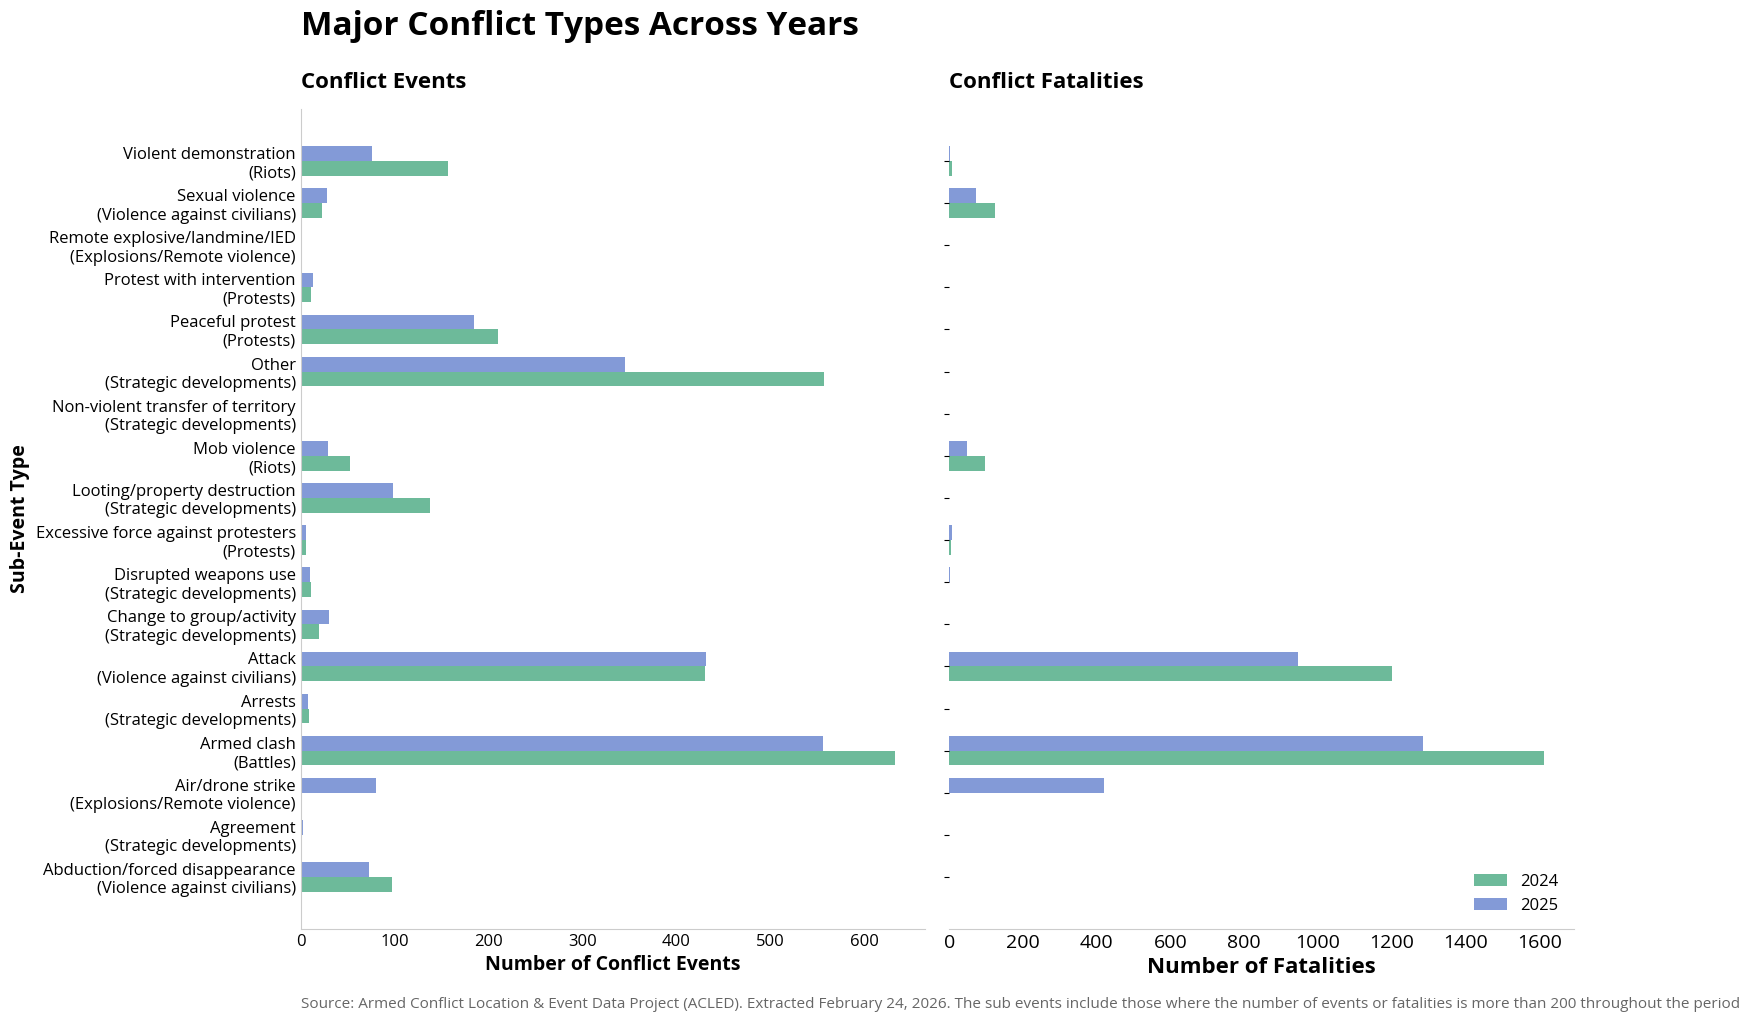

In [269]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

# Set Open Sans font
plt.rcParams['font.family'] = 'Open Sans'


# Create a mapping of sub_event_type to event_type
sub_to_event_map = conflict_type.groupby('sub_event_type')['event_type'].first().to_dict()

# Pivot the data for both events and fatalities
conflict_pivot_events = conflict_type.pivot_table(
    index='sub_event_type', 
    columns='category', 
    values='nrEvents', 
    aggfunc='sum',
    fill_value=0
)

conflict_pivot_fatalities = conflict_type.pivot_table(
    index='sub_event_type', 
    columns='category', 
    values='nrFatalities', 
    aggfunc='sum',
    fill_value=0
)

# Create labels with event_type in brackets
labels_with_event_type = [f"{sub_event}\n({sub_to_event_map[sub_event]})" 
                          for sub_event in conflict_pivot_events.index]

# Create side-by-side horizontal bar charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10), sharey=True)

# Set colors
color_before = '#54AE89'
color_after = '#6D88D1'
spine_color = '#CCCCCC'

# Set the bar height and positions
y = range(len(conflict_pivot_events.index))
height = 0.35

# Plot 1: Events
ax1.barh([i - height/2 for i in y], conflict_pivot_events[2024], 
         height, label='2024', color=color_before, alpha=0.85)
ax1.barh([i + height/2 for i in y], conflict_pivot_events[2025], 
         height, label='2025', color=color_after, alpha=0.85)

ax1.set_xlabel('Number of Conflict Events', fontsize=14, fontweight='bold', fontfamily='Open Sans')
ax1.set_ylabel('Sub-Event Type', fontsize=14, fontweight='bold', fontfamily='Open Sans')
ax1.set_title('Conflict Events', fontsize=16, fontweight='bold', pad=15, fontfamily='Open Sans', loc='left')
ax1.set_yticks(y)
ax1.set_yticklabels(labels_with_event_type, fontfamily='Open Sans', fontsize=14)
ax1.tick_params(axis='x', labelsize=12, length=0)
ax1.tick_params(axis='y', labelsize=12, length=0)
for label in ax1.get_yticklabels():
    label.set_fontfamily('Open Sans')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_color(spine_color)
ax1.spines['bottom'].set_color(spine_color)
ax1.grid(False)

# Plot 2: Fatalities
ax2.barh([i - height/2 for i in y], conflict_pivot_fatalities[2024], 
         height, label='2024', color=color_before, alpha=0.85)
ax2.barh([i + height/2 for i in y], conflict_pivot_fatalities[2025], 
         height, label='2025', color=color_after, alpha=0.85)

ax2.set_xlabel('Number of Fatalities', fontsize=16, fontweight='bold', fontfamily='Open Sans')
ax2.set_title('Conflict Fatalities', fontsize=16, fontweight='bold', pad=15, fontfamily='Open Sans', loc='left')
ax2.tick_params(axis='x', labelsize=14, length=0)
for label in ax2.get_xticklabels():
    label.set_fontfamily('Open Sans')
ax2.legend(loc='lower right', frameon=False, prop={'family': 'Open Sans', 'size': 12})
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_color(spine_color)
ax2.grid(False)

# Add main title
fig.suptitle('Major Conflict Types Across Years', fontsize=24, fontweight='bold', 
             fontfamily='Open Sans', x=0.08, ha='left', y=0.999)

# Add source at the bottom left
fig.text(0.08, 0.001, f'Source: Armed Conflict Location & Event Data Project (ACLED). Extracted {extracted_date_formatted}. The sub events include those where the number of events or fatalities is more than 200 throughout the period', 
         ha='left', fontsize=11, fontfamily='Open Sans', style='italic', color='#666666')

plt.tight_layout()
plt.subplots_adjust(top=0.90, bottom=0.08, left=0.08)
plt.show()


## Major Conflict Topics

This section uses natural language processing to identify distinct protest topics/themes:

**Method**: TF-IDF (Term Frequency-Inverse Document Frequency) with K-means clustering identifies groups of conflict events that share similar language and themes.

**Process**:
1. **Text Preprocessing**: Apply word normalization and custom stopwords to clean the data
2. **TF-IDF Vectorization**: Convert text to numerical features, weighting words by their importance


**Time Period Analysis**: We run this analysis separately for before and after regime change

In [270]:
import pandas as pd
import numpy as np
from acled_conflict_analysis.text_analysis import (
    plot_wordcloud_comparison,
    get_word_counts,
    get_ngram_counts,
    get_tfidf_word_frequencies,
    custom_stopwords
)

# Auto-reload modules when they change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [271]:
before_regime = data[data['category']==2024]
after_regime = data[data['category']==2025]

In [272]:
additional_stopwords = [
    'fatality', 'fatalities',
    'casualty', 'casualties', 
    'injury', 'injuries',
    'unknown', 'countryside', 'regime',
    'syria', 'clash', 'man', 'fighter', 'killed', 'killing', 'gang', 'delmas', 'police'
]
custom_stopwords = custom_stopwords + additional_stopwords

In [273]:
word_counts_before_regime = get_word_counts(
    before_regime, 
    column_name='notes', 
    custom_stopwords=custom_stopwords
)

word_counts_after_regime = get_word_counts(
    after_regime, 
    column_name='notes', 
    custom_stopwords=custom_stopwords
)

In [274]:
from acled_conflict_analysis.text_analysis import get_tfidf_word_frequencies

word_normalizations = {
    'moroccan': 'morocco',
    'moroccans': 'morocco',
    'palestinian': 'palestine',
    'palestinians': 'palestine',
    'israeli': 'israel',
    'israelis': 'israel',
    'egyptian': 'egypt',
    'egyptians': 'egypt',
    'iraqi': 'iraq',
    'iraqis': 'iraq',
    'syrian': 'syria',
    'syrians': 'syria',
    'lebanese': 'lebanon',
    'yemeni': 'yemen',
    'yemenis': 'yemen',
    'salaries': 'salary',
    'retirees': 'retirement',
    'retired': 'retirement',
}

# Add normalized forms to stopwords to ensure they're removed after normalization
normalized_stopwords = custom_stopwords + list(set(word_normalizations.values()))

tfidf_before_regime = get_tfidf_word_frequencies(
    df=before_regime,
    text_column='notes',
    custom_stopwords=normalized_stopwords,
    word_normalizations=word_normalizations,
    top_n=100
)

tfidf_after_regime = get_tfidf_word_frequencies(
    df=after_regime,
    text_column='notes',
    custom_stopwords=normalized_stopwords,
    word_normalizations=word_normalizations,
    top_n=100
)

# Manually filter out stopwords from results (in case normalization happened after initial filtering)
stopwords_set = set(normalized_stopwords)
tfidf_before_regime = {k: v for k, v in tfidf_before_regime.items() if k not in stopwords_set}
tfidf_after_regime = {k: v for k, v in tfidf_after_regime.items() if k not in stopwords_set}

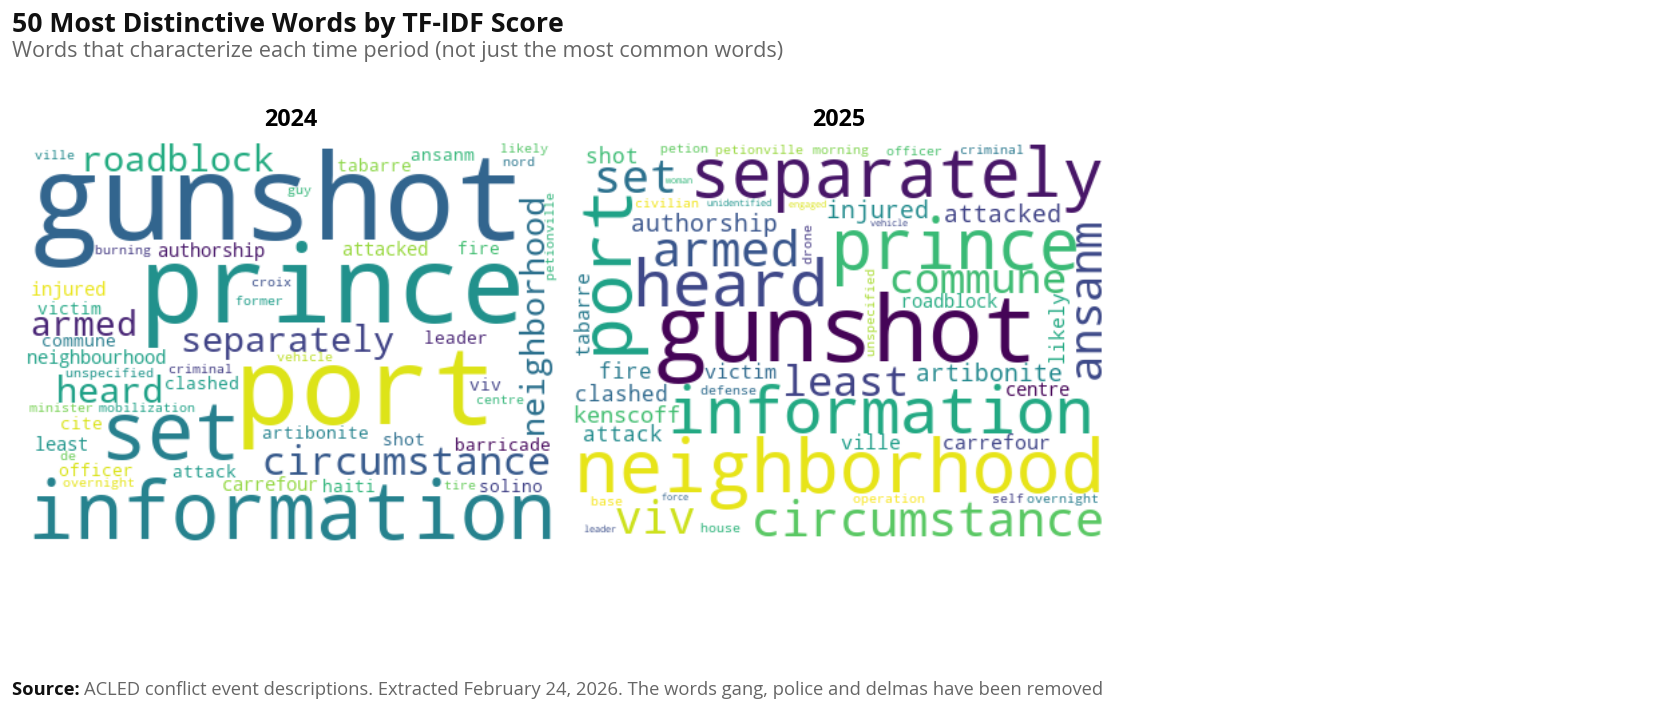

In [275]:
plot_wordcloud_comparison(
    word_freq_dicts=[tfidf_before_regime, tfidf_after_regime],
    subplot_titles=[2024, 2025],
    main_title='50 Most Distinctive Words by TF-IDF Score',
    subtitle='Words that characterize each time period (not just the most common words)',
    note=f'ACLED conflict event descriptions. Extracted {extracted_date_formatted}. The words gang, police and delmas have been removed',
    figsize=(14, 6),
    ncols=3,
    max_words =50
)

- 'roadblocks' is seen as a distinctive word in 2024 and 2025 notes about conflict events. 